# 1. 단순선형 회귀분석

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
#회귀분석의 정규성 확인
from statsmodels.api import qqplot

import warnings 
warnings.filterwarnings('ignore')

matplotlib.rc("font", family="Malgun Gothic")
matplotlib.rc("axes", unicode_minus = False)

### 1) 변수 간의 경향성 파악

,UNITS,MINUTES
UNITS,1.000,0.994
MINUTES,0.994,1.000


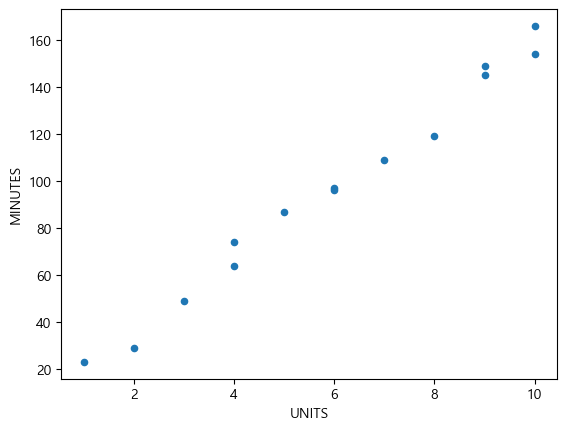

In [10]:
df_raw = pd.read_csv("./실습화일/2. Big Data 분석/부품수리시간.csv")

#변수 간의 경향성 파악 
#그래프(산점도) 분석 
df_raw.plot.scatter(x = "UNITS", y = "MINUTES")

#상관관계 분석
display(df_raw.corr(method = "pearson").round(3))

상관 계수가 0.994로 두 변수 간에는 매우 높은 선형 관계가 있음
그래프를 보아 UNITS(설명변수)가 증가함에 따라 MINUTES(수리시간)도 증가

### 2) 회귀 모델 생성

In [11]:
#선형 회귀 분석(formula 이용), 상수항은 자동으로 추가), y ~ X
reg_model = smf.ols(formula = "MINUTES ~ UNITS", data=df_raw)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                MINUTES   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     943.2
Date:                Sun, 09 Jul 2023   Prob (F-statistic):           8.92e-13
Time:                        10:15:35   Log-Likelihood:                -42.374
No. Observations:                  14   AIC:                             88.75
Df Residuals:                      12   BIC:                             90.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1617      3.355      1.240      0.2

### 3) 잔차의 기본가정 검토 (정규성, 등분산성, 독립성 확인)

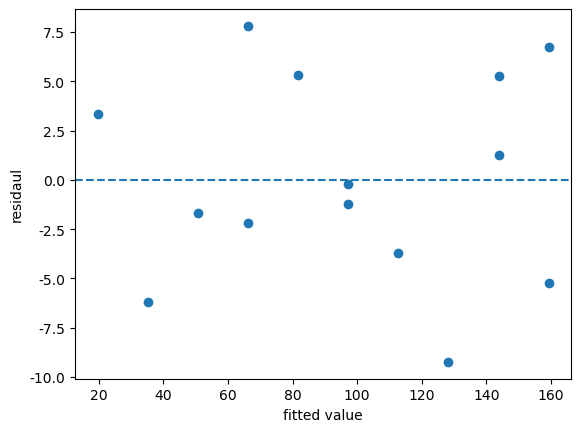

In [13]:
#등분산성 검정 
plt.scatter(reg_result.fittedvalues,reg_result.resid)
plt.xlabel("fitted value"); plt.ylabel("residaul")
plt.axhline(y=0, linestyle="--")

잔차가 y=0을 기준으로 random하게 산포되어 있으므로 등분산성 만족

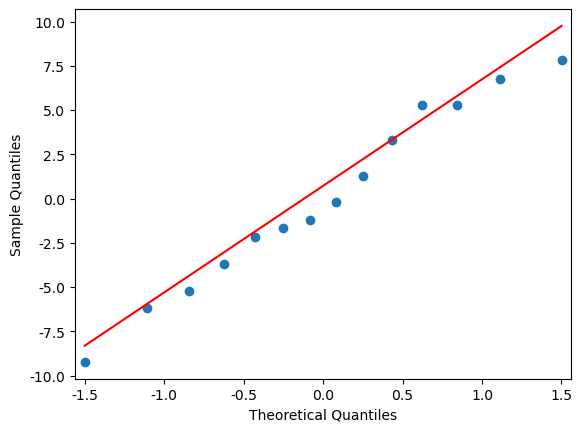

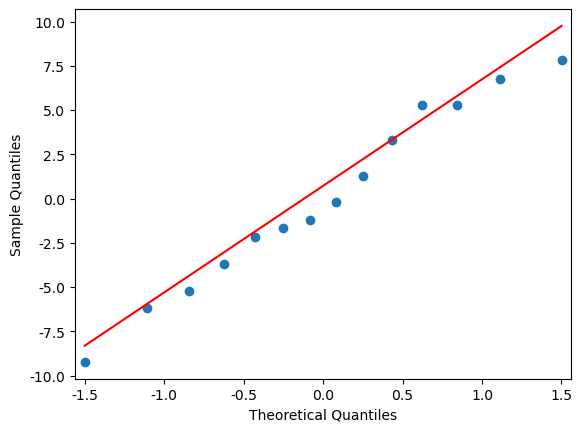

In [14]:
#정규성 검정 : Q-Q plot 이용
qqplot(reg_result.resid,line="q")

정규분포 직선을 중싐으로 분포하므로 정규분포를 따름

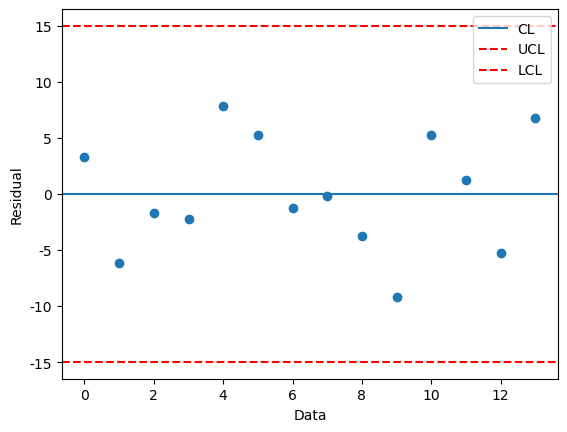

In [15]:
#독립성 검정 
plt.scatter(df_raw.index, reg_result.resid, marker="o")
plt.xlabel("Data");
plt.ylabel("Residual")
plt.axhline(y=0, linestyle="-", label='CL')
plt.axhline(y=3*np.std(reg_result.resid), linestyle="--",color="red",label = 'UCL')
plt.axhline(y=-3*np.std(reg_result.resid), linestyle="--",color="red",label = 'LCL')
plt.legend();
plt.show()

잔차가 y=0을 기준으로 관리상하한을 벗어나지 않고 random하게 산포되어 있으므로 독립성을 만족

y = 4.1617 + 15.5088*Units

# 2. 다중선형 회귀분석

In [24]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.api import qqplot,add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import warnings 
warnings.filterwarnings('ignore')

matplotlib.rc("font", family="Malgun Gothic")
matplotlib.rc("axes", unicode_minus = False)

In [40]:
df_raw = pd.read_csv('./실습화일/1 Big Data 분석 기초/체질검사.csv', encoding = 'euc-kr')
display(df_raw.head())

df_raw.isnull().sum()

# 계산에 불필요한 단위제거
df_raw[['WEIGHT','WEIGHT_UNIT']] = df_raw['WEIGHT'].str.split(expand=True)
df_raw[['HEIGHT','HEIGHT_UNIT']] = df_raw['HEIGHT'].str.split(expand=True)
df_raw['WEIGHT'] = df_raw['WEIGHT'].astype('float64')
df_raw['HEIGHT'] = df_raw['HEIGHT'].astype('float64')
print(df_raw.info())

df_raw=df_raw.drop(['WEIGHT_UNIT','HEIGHT_UNIT'],axis = 1)
df_raw_dummy = pd.get_dummies(df_raw,drop_first=True)
df_raw_dummy.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,GENDER
0,35.2,46,363.15 lb,72.25 inch,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,남성
1,11.8,27,168 lb,71.25 inch,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,남성
2,22.2,69,177.75 lb,68.5 inch,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,남성
3,10.6,57,147.75 lb,65.75 inch,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,여성
4,47.5,51,219 lb,64 inch,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,여성


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FAT          252 non-null    float64
 1   AGE          252 non-null    int64  
 2   WEIGHT       252 non-null    float64
 3   HEIGHT       252 non-null    float64
 4   NECK         252 non-null    float64
 5   CHEST        252 non-null    float64
 6   ABDOMEN      252 non-null    float64
 7   HIP          252 non-null    float64
 8   THIGH        252 non-null    float64
 9   KNEE         252 non-null    float64
 10  ANKLE        252 non-null    float64
 11  BICEPS       252 non-null    float64
 12  FOREARM      252 non-null    float64
 13  WRIST        252 non-null    float64
 14  GENDER       252 non-null    object 
 15  WEIGHT_UNIT  252 non-null    object 
 16  HEIGHT_UNIT  252 non-null    object 
dtypes: float64(13), int64(1), object(3)
memory usage: 33.6+ KB
None


,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,GENDER_여성
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,0
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,0
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,0
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,1
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,1


### 1) 변수 간의 경향성 파악

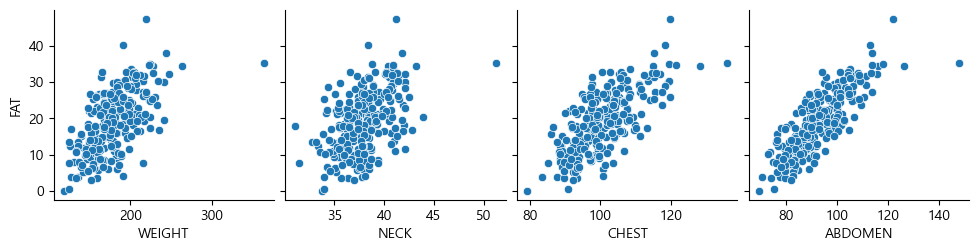

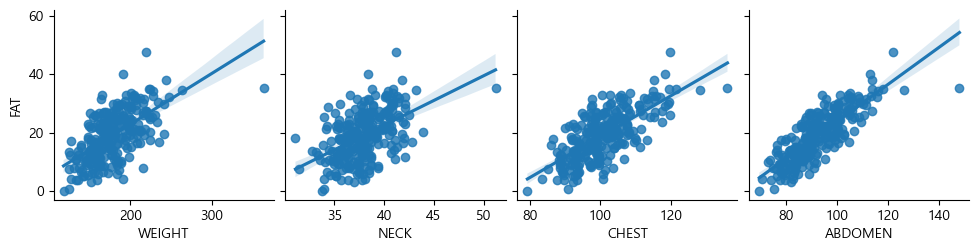

In [41]:
sns.pairplot(df_raw_dummy, y_vars="FAT",x_vars=["WEIGHT","NECK","CHEST","ABDOMEN"])
sns.pairplot(df_raw_dummy, y_vars="FAT",x_vars=["WEIGHT","NECK","CHEST","ABDOMEN"],kind="reg")

목표변수(체질 비만도, FAT)와 다수 설명변수간의 선형관계 확인.

산점도에서 이상치 확인

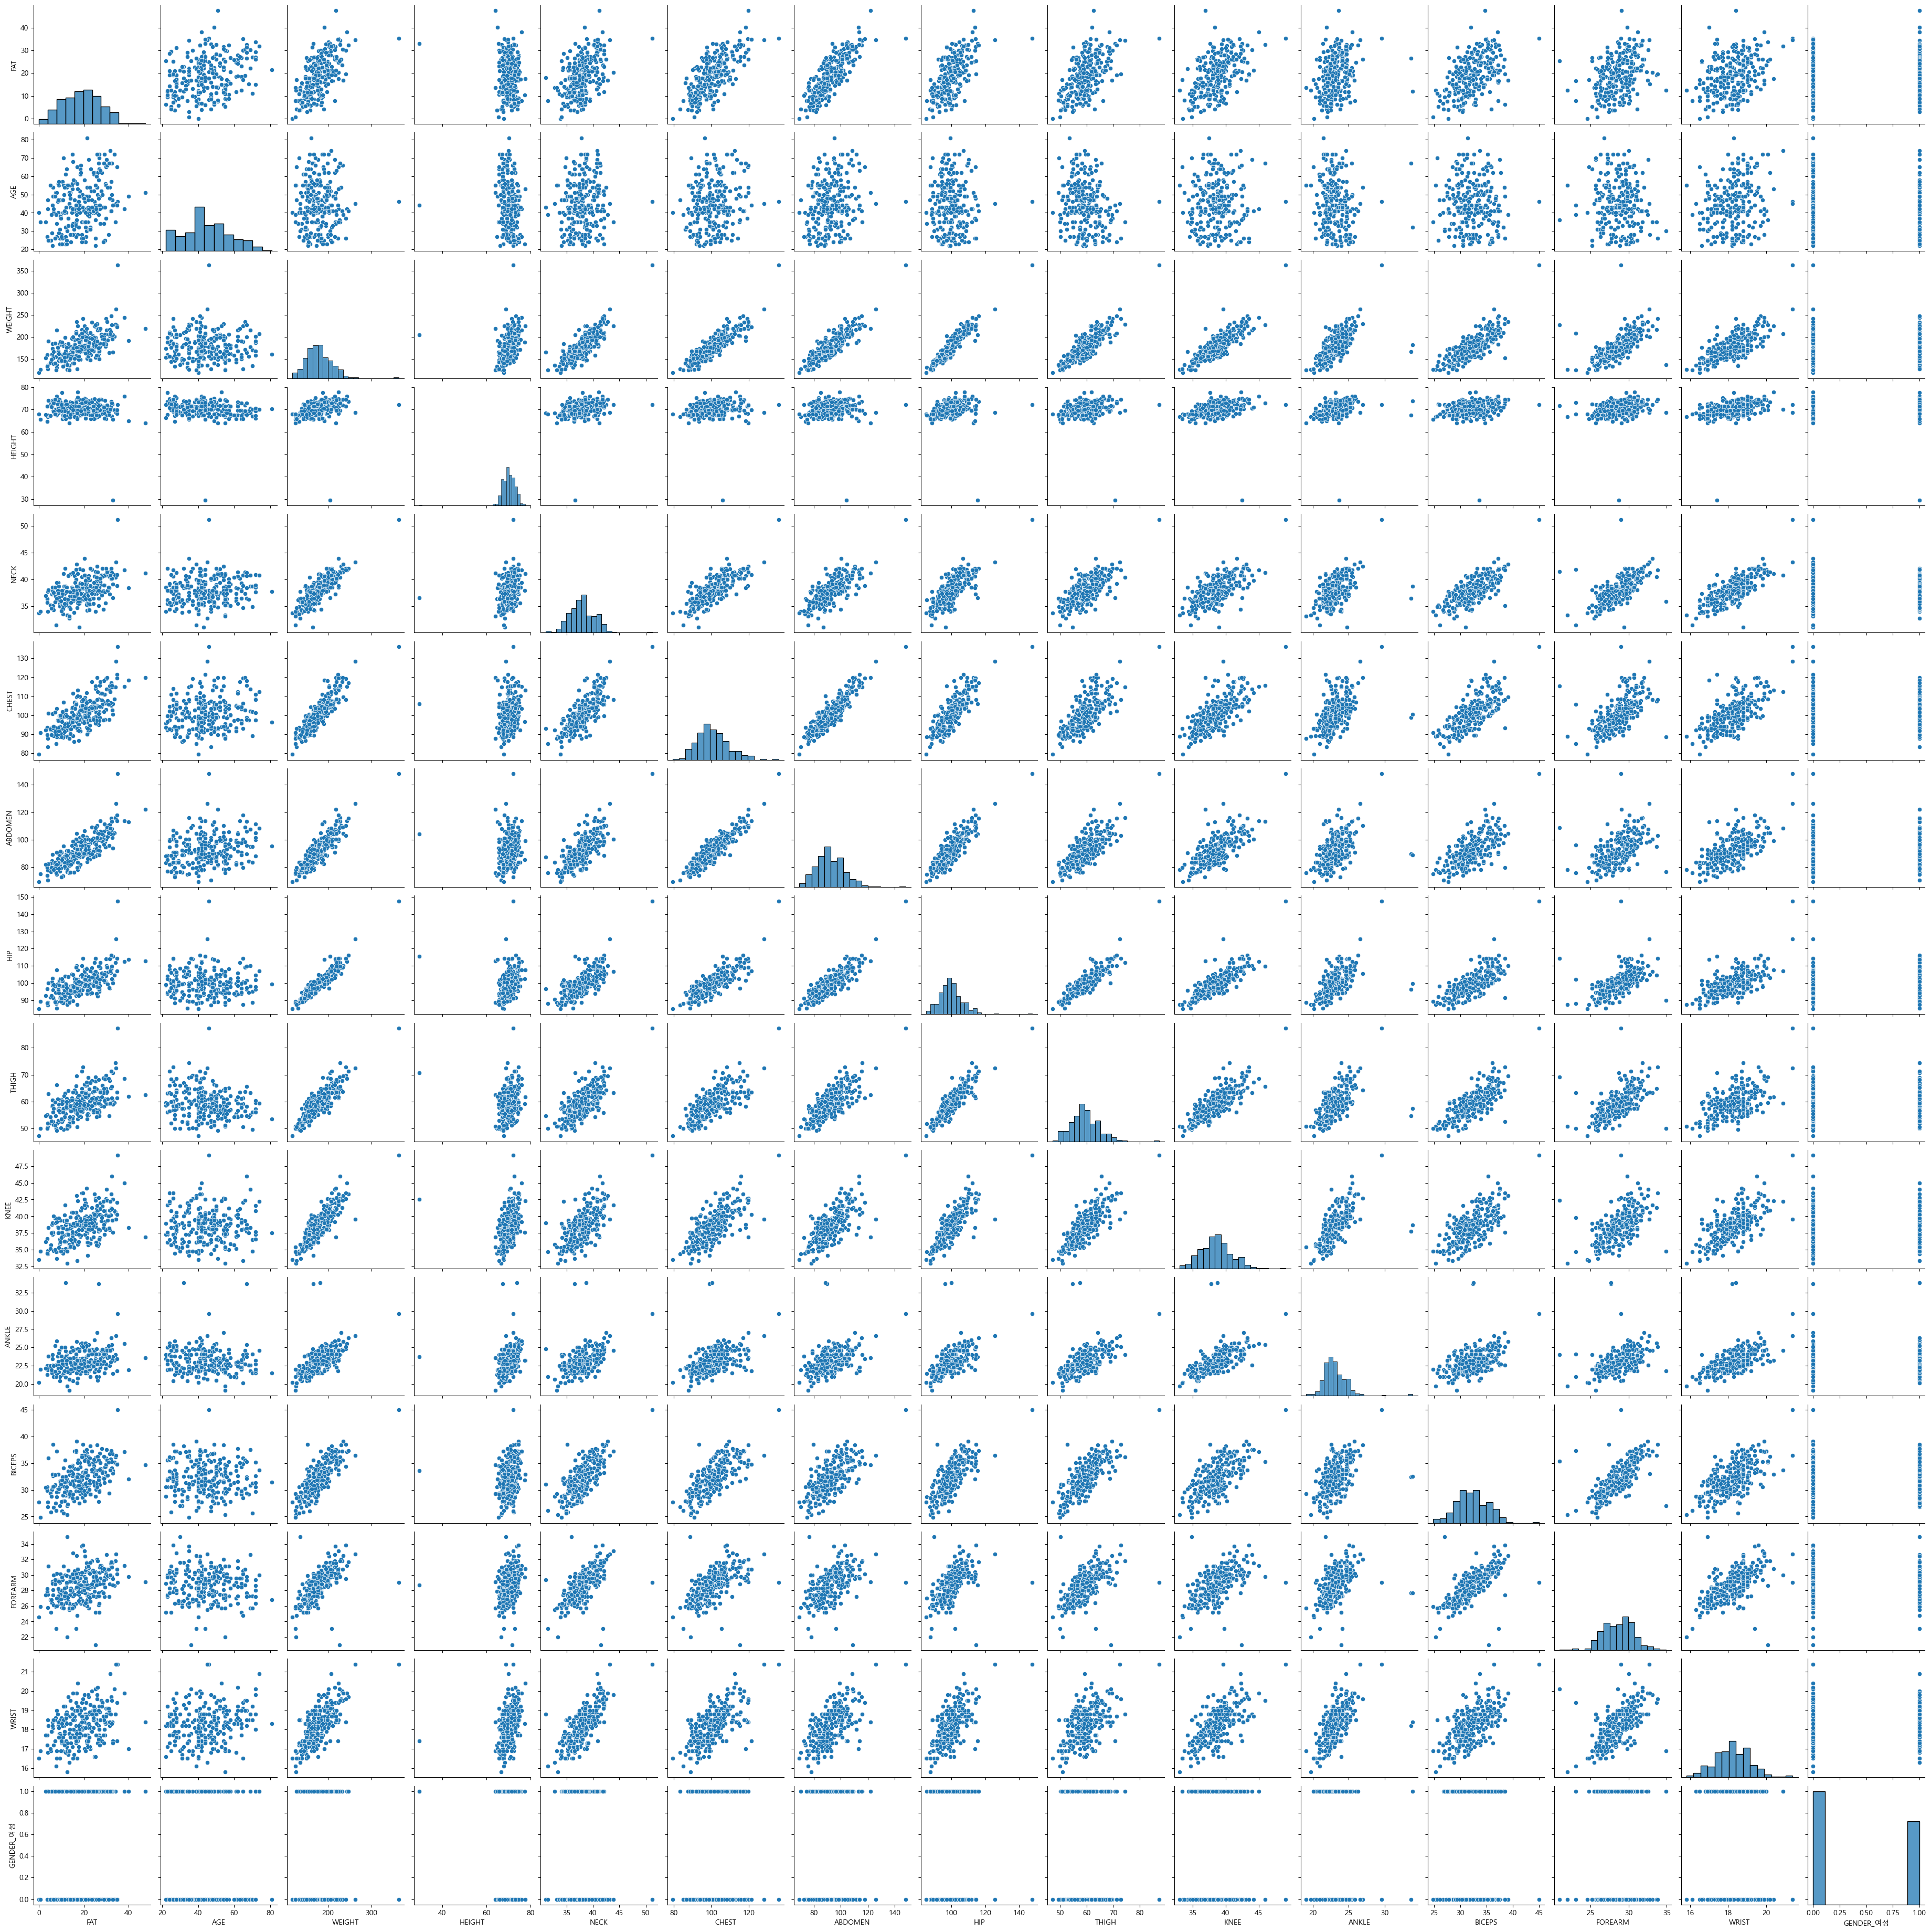

In [27]:
sns.pairplot(df_raw_dummy)

목표변수(FAT)와 선형관계가 있는 설명변수 확인됨
설명변수 간의 선형관계 확인됨 (WEIGHT, NECK)

-> 설명변수 간의 다중공선성 처리 필요

In [28]:
df_raw_dummy.corr().round(3)

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,GENDER_여성
FAT,1.000,0.291,0.612,-0.089,0.491,0.703,0.813,0.625,0.560,0.509,0.266,0.493,0.361,0.347,-0.033
AGE,0.291,1.000,-0.013,-0.172,0.114,0.176,0.230,-0.050,-0.200,0.018,-0.105,-0.041,-0.085,0.214,-0.063
WEIGHT,0.612,-0.013,1.000,0.308,0.831,0.894,0.888,0.941,0.869,0.853,0.614,0.800,0.630,0.730,-0.009
HEIGHT,-0.089,-0.172,0.308,1.000,0.254,0.135,0.088,0.170,0.148,0.286,0.265,0.208,0.229,0.322,0.025
NECK,0.491,0.114,0.831,0.254,1.000,0.785,0.754,0.735,0.696,0.672,0.478,0.731,0.624,0.745,0.010
CHEST,0.703,0.176,0.894,0.135,0.785,1.000,0.916,0.829,0.730,0.719,0.483,0.728,0.580,0.660,-0.014
ABDOMEN,0.813,0.230,0.888,0.088,0.754,0.916,1.000,0.874,0.767,0.737,0.453,0.685,0.503,0.620,-0.017
HIP,0.625,-0.050,0.941,0.170,0.735,0.829,0.874,1.000,0.896,0.823,0.558,0.739,0.545,0.630,-0.042
THIGH,0.560,-0.200,0.869,0.148,0.696,0.730,0.767,0.896,1.000,0.799,0.540,0.761,0.567,0.559,-0.040
KNEE,0.509,0.018,0.853,0.286,0.672,0.719,0.737,0.823,0.799,1.000,0.612,0.679,0.556,0.665,-0.034


### 2) 회귀모델 생성

선형회귀분석 가설

귀무가설 : 모든 회귀 계수가 0이며, 독립 변수들이 종속 변수에 영향을 미치지 않는다.

대립가설 : 적어도 하나의 회귀 계수가 0이 아니며, 적어도 하나의 독립 변수가 종속 변수에 영향을 미친다.

In [42]:
df_train, df_test = train_test_split(df_raw_dummy, test_size=0.3, random_state=1234)
print("train data size: {}".format(df_train.shape))
print("test data size: {}".format(df_test.shape))

reg_model = smf.ols(formula = "FAT ~ AGE + WEIGHT + HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH + KNEE + \
                                ANKLE + BICEPS + FOREARM + WRIST + GENDER_여성", data=df_train)

reg_result = reg_model.fit()
print(reg_result.summary())

train data size: (176, 15)
test data size: (76, 15)
                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     38.25
Date:                Sun, 09 Jul 2023   Prob (F-statistic):           6.43e-44
Time:                        11:27:53   Log-Likelihood:                -495.19
No. Observations:                 176   AIC:                             1020.
Df Residuals:                     161   BIC:                             1068.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


### 3) 다중공선성 확인

다중공선성이 증가하면 독립변수의 공분산 행렬의 조건수 증가 >> 과최적화 가능성 상승

In [43]:
df_train_x = df_train.drop('FAT',axis = 1)
df_train_x_const = add_constant(df_train_x)
df_vif = pd.DataFrame()
df_vif["variable"] = df_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_x_const.values, i)\
                for i in range(df_train_x_const.shape[1])]
df_vif.sort_values("VIF",ascending=True).round(2)

,variable,VIF
14,GENDER_여성,1.04
3,HEIGHT,1.65
12,FOREARM,2.03
10,ANKLE,2.23
1,AGE,2.43
11,BICEPS,3.46
13,WRIST,3.52
4,NECK,4.29
9,KNEE,5.14
8,THIGH,9.02


VIF 값이 4399.51로 매우 크게 나타나는 이유는 "const" 변수가 모든 다른 변수들과 강한 선형 상관관계를 가지고 있기 때문입니다. 

"const" 변수는 다른 변수들과 독립적이지 않고, 다른 변수들에 의해 크게 설명될 수 있는 변수입니다.

### VIF (다중공선성) 이 높은 변수를 제거하며 2번, 3번 반복

In [44]:
reg_model = smf.ols(formula = "FAT ~ AGE + HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH + KNEE + \
                                ANKLE + BICEPS + FOREARM + WRIST + GENDER_여성", data=df_train)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     40.16
Date:                Sun, 09 Jul 2023   Prob (F-statistic):           6.67e-44
Time:                        11:27:54   Log-Likelihood:                -497.32
No. Observations:                 176   AIC:                             1023.
Df Residuals:                     162   BIC:                             1067.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1903      8.664      0.253      0.8

In [45]:
df_train_x = df_train.drop(['FAT','WEIGHT'],axis = 1)
df_train_x_const = add_constant(df_train_x)
df_vif = pd.DataFrame()
df_vif["variable"] = df_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_x_const.values, i)\
                for i in range(df_train_x_const.shape[1])]
df_vif.sort_values("VIF",ascending=True).round(2)

,variable,VIF
13,GENDER_여성,1.04
2,HEIGHT,1.36
11,FOREARM,2.03
9,ANKLE,2.11
1,AGE,2.34
10,BICEPS,3.37
12,WRIST,3.42
3,NECK,3.81
8,KNEE,4.65
4,CHEST,8.81


ABDOMEN 이 12.9로 다중공선성이 의심되나, 

목표변수에 가장 영향이 큰 변수이므로 제거하지 않음 (다중공선성 일부 해결)

다중공선성을 제거했다면 유의미한 변수 선택 (P-value 가 큰 것을 하나씩 반복제거)

In [46]:
reg_model = smf.ols(formula = "FAT ~ HEIGHT + NECK + ABDOMEN + HIP + FOREARM ", data=df_train)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     102.3
Date:                Sun, 09 Jul 2023   Prob (F-statistic):           2.18e-49
Time:                        11:27:55   Log-Likelihood:                -501.89
No. Observations:                 176   AIC:                             1016.
Df Residuals:                     170   BIC:                             1035.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7817      7.302      0.381      0.7

In [47]:
df_train_x = df_train[['HEIGHT', 'NECK','ABDOMEN','HIP','FOREARM']]
df_train_x_const = add_constant(df_train_x)
df_vif = pd.DataFrame()
df_vif["variable"] = df_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_x_const.values, i)\
                for i in range(df_train_x_const.shape[1])]
df_vif.sort_values("VIF",ascending=True).round(2)

,variable,VIF
1,HEIGHT,1.14
5,FOREARM,1.57
2,NECK,2.87
3,ABDOMEN,4.91
4,HIP,4.95
0,const,516.31


다중공선성 재확인하였으나 VIF가 10 미만으로 다중공선성 해결

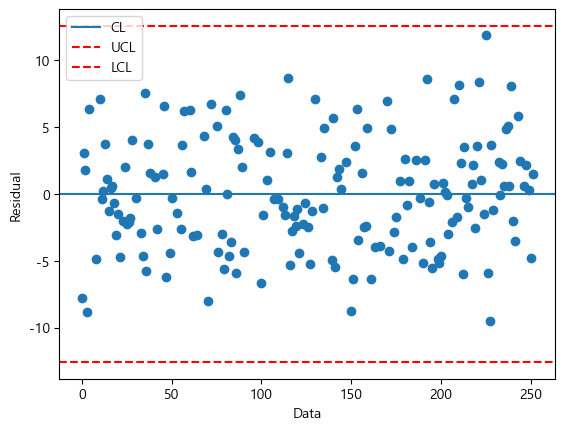

In [48]:
#독립성 검정 
plt.scatter(df_train.index, reg_result.resid, marker="o")
plt.xlabel("Data");
plt.ylabel("Residual")
plt.axhline(y=0, linestyle="-", label='CL')
plt.axhline(y=3*np.std(reg_result.resid), linestyle="--",color="red",label = 'UCL')
plt.axhline(y=-3*np.std(reg_result.resid), linestyle="--",color="red",label = 'LCL')
plt.legend();
plt.show()

In [39]:
train_pred = reg_result.predict(df_train)
test_pred = reg_result.predict(df_test)
print("train data의 결정계수:", r2_score(df_train['FAT'],train_pred))
print("test data의 결정계수:", r2_score(df_test['FAT'],test_pred))

train data의 결정계수: 0.7476037244115142
test data의 결정계수: 0.6911707784681422


# 2-2. 후진제거법을 이용한 변수 선택 (앞에서 뭐한거지...)

일반적으로 직접선택이 아닌 전진제거, 후진제거 등의 방법으 이용하여 변수를 선택

### 1) 후진제거법을 이용한 변수 선택

In [66]:
# RFE 함수 : 입력된 모델을 이용하여 변수중요도가 낮은 순으로 순차적으로 제거
df_train_y = df_train['FAT']
df_train_x = df_train.drop('FAT',axis = 1)

model = LinearRegression()
# 전체 변수 중 5개의 변수가 남을 때까지 변수 선택
rfe = RFE(estimator=model, n_features_to_select=5).fit(df_train_x,df_train_y)
selected_cols = df_train_x.columns[rfe.support_]
removed_cols = df_train_x.columns[~rfe.support_]

print("Selected Var: {}".format(selected_cols))
print("Removed Var: {}".format(removed_cols))

Selected Var: Index(['NECK', 'ABDOMEN', 'FOREARM', 'WRIST', 'GENDER_쩔짤쩌쨘'], dtype='object')
Removed Var: Index(['AGE', 'WEIGHT', 'HEIGHT', 'CHEST', 'HIP', 'THIGH', 'KNEE', 'ANKLE',
       'BICEPS'],
      dtype='object')


NECK, ABDOMEN, ANKLE, FOREARM, WRIST 변수 선택

### 2) 모델 생성

In [67]:
rfe_reg_model = smf.ols(formula="FAT ~ NECK + ABDOMEN + ANKLE + FOREARM + WRIST",data = df_train)
rfe_reg_model = rfe_reg_model.fit()
print(rfe_reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     73.17
Date:                Mon, 27 Feb 2023   Prob (F-statistic):           6.49e-38
Time:                        16:35:01   Log-Likelihood:                -439.27
No. Observations:                 151   AIC:                             890.5
Df Residuals:                     145   BIC:                             908.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.3095      7.539     -1.633      0.1

ANKLE, FOREARM 는 P값이 0.05보다 크지만 그렇다고 해서 반드시 유의하지 않은 것은 아니다

수작업으로 변수 선택한 내용과 다름

<AxesSubplot:>

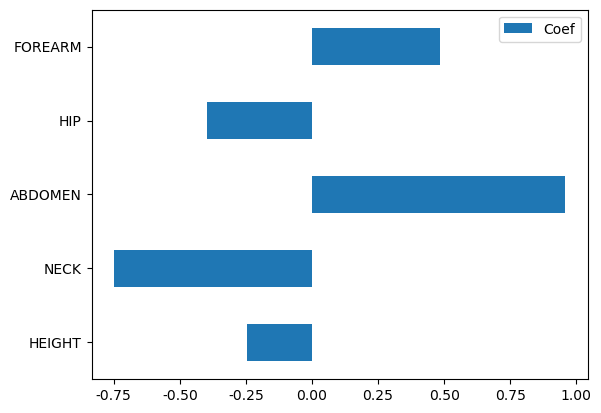

In [68]:
# 비표준화 회귀계수
df_reg_coef = pd.DataFrame({"Coef":reg_result.params.values[1:]},index = ['HEIGHT','NECK','ABDOMEN','HIP','FOREARM'])
df_reg_coef.plot.barh(y="Coef")

FOREARM과 ABDOMEN는 커질수록 FAT이 높음